# 6. Decision Trees and Ensemble Learning

## 6.1 Credit Scoring Project
In this session we'll learn about decision trees and ensemble learning algorithms. The questions that we try to address this week are, "What are decision trees? How are they different from ensemble algorithms? How can we implement and fine-tune these models to make binary classification predictions?"

To be specific, we'll use [credit scoring data](https://github.com/gastonstat/CreditScoring/blob/master/CreditScoring.csv) to build a model that predicts whether a bank should lend loan to a client or not. The bank takes these decisions based on the historical record.

In the credit scoring classification problem,

- if the model returns 0, this means, the client is very likely to payback the loan and the bank will approve the loan.
- if the model returns 1, then the client is considered as a defaulter and the bank may not approval the loan.

## 6.2 Data Cleaning and Preparation
In this section we clean and prepare the dataset for the model which involves the following steps:

- Reformat categorical columns (status, home, marital, records, and job) by mapping with appropriate values.
- Replace the maximum value of income, assests, and debt columns with NaNs.
- Replace the NaNs in the dataframe with 0 (will be shown in the next lesson).
- Extract only those rows in the column status who are either ok or default as value.
- Split the data in a two-step process which finally leads to the distribution of 60% train, 20% validation, and 20% test sets with random seed to 11.
- Prepare target variable status by converting it from categorical to binary, where 0 represents ok and 1 represents default.
- Finally delete the target variable from the train/val/test dataframe.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


In [5]:
df = pd.read_csv('credit_scoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
# replacing the categorical variables
# represented by numbers to text

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
# replace large numbers 99999999.0 in max

# df.income.max()
# df.income.replace(to_replace=99999999, value=np.nan)

# we can run the code above for all such columns
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
df.status.value_counts()

# unk is just one and can be removed

df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
# split the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

# reset index for the different dataset
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
# our weights

y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [14]:
# remove the dependent variable 
# from each dataframes

del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decison Trees
Decision Trees are powerful algorithms, capable of fitting complex datasets. The decision trees make predictions based on the bunch of if/else statements by splitting a node into two or more sub-nodes.

With versatility, the decision tree is also prone to overfitting. One of the reason why this algorithm often overfits because of its depth. It tends to memorize all the patterns in the train data but struggle to performs well on the unseen data (validation or test set).

To overcome with overfitting problem, we can reduce the complexity of the algorithm by reducing the depth size.

The decision tree with only a single depth is called decision stump and it only has one split from the root.

##### Classes, functions, and methods:

- `DecisionTreeClassifier`: classification model from sklearn.tree class.
- `max_depth`: hyperparameter to control the depth of decision tree algorithm.
- `export_text`: method from sklearn.tree class to display the text report showing the rules of a decision tree.

In [15]:
# a decision tree to assess risk

def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'

    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [16]:
# we want to check our decision tree on a customer
# first customer 0
xi_0 = df_train.iloc[0].to_dict()

# first customer 20
xi_20 = df_train.iloc[20].to_dict()

assess_risk(xi_0), assess_risk(xi_20)

('ok', 'default')

In [17]:
# 2 cells up, our decision tree was manually coded
# but the rules can be learned from the data
# decision trees can also be used for solving regression problems
# we need dictionary vectorizer because we have categorical variables

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

In [18]:
# we need to train our train dataframe to a list of dictionaries
# train_dicts = df_train.to_dict(orient='records')
# replace missing values with 0s
train_dicts = df_train.fillna(0).to_dict(orient='records')

# create an instance of the DictVectorizer
dv = DictVectorizer(sparse=False)

# fit and transform the data in order to 
# turn the list of dictionaries into a feature matrix which we will
# use to train a model
X_train = dv.fit_transform(train_dicts)

# get feature_names
# dv.get_feature_names_out()

In [19]:
# train our decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train) # this creates an error due to NAN values

# df_train.isnull().sum()

DecisionTreeClassifier()

In [20]:
# test our decision tree on the val dataframe
val_dicts = df_val.fillna(0).to_dict(orient='records')

# we only transform
X_val = dv.transform(val_dicts)

In [21]:
# predict
y_pred = dt.predict_proba(X_val)[:, 1]

In [22]:
# we want to check the score
from sklearn.metrics import roc_auc_score

# training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'train: {auc}')

# this cell gave a 1 which means we have 'overfitting' where our data
# has memorized the data but fails to generalize hence
# failing at the site of data it hasn't seen before.
# we solve this problem by reducing 
# the maximum depth of our tree (at dt above) where
# we created an instance of DecisionTreeClassifier


# val dataset
y_pred = dt.predict_proba(X_val)[:, 1] # type: ignore
auc = roc_auc_score(y_val, y_pred)
print(f'val: {auc}')




train: 1.0
val: 0.6791159090358674


In [23]:
# reduce the max_depth of DecisionTreeClassifier to 1
dt = DecisionTreeClassifier(max_depth=1) # decision stump when depth 1
dt.fit(X_train, y_train)

# training dataset
y_pred = dt.predict_proba(X_train)[:, 1] # type: ignore
auc = roc_auc_score(y_train, y_pred)
print(f'train: {auc}')

# val dataset
y_pred = dt.predict_proba(X_val)[:, 1] # type: ignore
auc = roc_auc_score(y_val, y_pred)
print(f'val: {auc}')




train: 0.6282660131823559
val: 0.6058644740984719


In [24]:
# visualize the decision tree to know the rule it learned
from sklearn.tree import export_text

from sklearn.tree import export_graphviz

print(export_text(dt, feature_names=dv.get_feature_names_out()))
# print(export_graphviz(dt))


|--- records=no <= 0.50
|   |--- class: 1
|--- records=no >  0.50
|   |--- class: 0



The result above signifies that if the feature "records" is <= 0.50, then it predicts "default" and "ok" when the it is > 0.5. Where the decision ends is called the leaf or node

## 6.4 Decision Tree Learning Algorithm
This lesson first reviews the topics learned in previous lesson about training a decision trees using sklearn, how to handle the model not generalizing due to overfitting of the data.

In this lesson, we learn about how to best split a decision tree and different classification criteria that can be used to split a tree. We dive deep using an example and splitting the tree using misclassification criteria. Additionally, different stopping criteria to break the iterative tree split criteria are discussed.

- structure of a decision tree: nodes & leaves
- depth of a decision tree & levels
- rules & conditions, thresholds
- misclassification rate
- impurity criteria (i.e. MSE)
- decision trees can be used to solve regression problems

##### Personal Note
In this session, we want to come up with all the possible threshold (i.e, max_depth) using any of our numerical columns. In this case of our dummy data, assets will be the column upon which we will train the decision trees in this session.

We can split the dataset into 2 halves where it is true and false, df_left(false) and df_right(true)

In [25]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [26]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [27]:
# our thresholds will be 2000, 3000, 4000, 5000, 8000, 9000

# create a list of thresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000, 9000]

In [28]:
from IPython.display import display

In [29]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    display(df_left.status.value_counts(normalize=True))
    # display(df_left.status.value_counts())
    display(df_right)
    display(df_right.status.value_counts(normalize=True))
    # display(df_right.status.value_counts())

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64


4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64

,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64


9000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,status


Series([], Name: proportion, dtype: float64)

#### The interpretation of the Preceeding cell

<table>
  <thead>
    <tr>
      <th>Threshold</th>
      <th>Decision Left</th>
      <th>Impurity Left</th>
      <th>Decision Right</th>
      <th>Impurity Right</th>
      <th>AVG</th>
    </tr>
  </thead>

  <tbody>
    <tr>
      <td>0</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>93%</td>
      <td>21%</td>
    </tr>
    <tr>
      <td>2000</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>33%</td>
      <td>16%</td>
    </tr>
    <tr>
      <td>3000</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>20%</td>
      <td>10%</td>
    </tr>
    <tr>
      <td>4000</td>
      <td>Default</td>
      <td>25%</td>
      <td>ok</td>
      <td>25%</td>
      <td>25%</td>
    </tr>
    <tr>
      <td>5000</td>
      <td>Default</td>
      <td>50%</td>
      <td>ok</td>
      <td>50%</td>
      <td>50%</td>
    </tr>
    <tr>
      <td>8000</td>
      <td>Default</td>
      <td>50%</td>
      <td>ok</td>
      <td>50%</td>
      <td>21%</td>
    </tr>
  </tbody>
</table>

The best threshold is 3000 because it has the lowest average with an impurity of 10%

In [30]:
# with 3 columns and 2 numerical features. we split by the debt feature

data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example



,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [31]:
# sort values by debt

df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [32]:
# our list of threshold

thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000, 9000],
    'debt': [500, 1000, 2000, 3000]
    }

for features, Ts in thresholds.items():
    for T in Ts:
        print(f"thresholds: {T}")
        print(f"features: {features}")
        df_left = df_example[df_example[features] <= T]
        df_right = df_example[df_example[features] > T]

        display(df_left)
        display(df_left.status.value_counts(normalize=True))
        # display(df_left.status.value_counts())
        display(df_right)
        display(df_right.status.value_counts(normalize=True))
        # display(df_right.status.value_counts())

    print()

thresholds: 0
features: assets


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

thresholds: 2000
features: assets


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

thresholds: 3000
features: assets


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

thresholds: 4000
features: assets


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

thresholds: 5000
features: assets


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

thresholds: 8000
features: assets


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

thresholds: 9000
features: assets


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,debt,status


Series([], Name: proportion, dtype: float64)


thresholds: 500
features: debt


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

thresholds: 1000
features: debt


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

thresholds: 2000
features: debt


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

thresholds: 3000
features: debt


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,debt,status


Series([], Name: proportion, dtype: float64)

#### The interpretation of the Preceeding cell

<table>
  <thead>
  <tr><th>Assets</th></tr>
    <tr>
      <th>Threshold</th>
      <th>Decision Left</th>
      <th>Impurity Left</th>
      <th>Decision Right</th>
      <th>Impurity Right</th>
      <th>AVG</th>
    </tr>
  </thead>

  <tbody>
    <tr>
      <td>0</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>93%</td>
      <td>21%</td>
    </tr>
    <tr>
      <td>2000</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>33%</td>
      <td>16%</td>
    </tr>
    <tr>
      <td>3000</td>
      <td>Default</td>
      <td>0%</td>
      <td>ok</td>
      <td>20%</td>
      <td>10%</td>
    </tr>
    <tr>
      <td>4000</td>
      <td>Default</td>
      <td>25%</td>
      <td>ok</td>
      <td>25%</td>
      <td>25%</td>
    </tr>
    <tr>
      <td>5000</td>
      <td>Default</td>
      <td>50%</td>
      <td>ok</td>
      <td>50%</td>
      <td>50%</td>
    </tr>
    <tr>
      <td>8000</td>
      <td>Default</td>
      <td>50%</td>
      <td>ok</td>
      <td>50%</td>
      <td>21%</td>
    </tr>

  <thead>
  <tr><th>Debt</th></tr>
    <tr>
      <th>Threshold</th>
      <th>Decision Left</th>
      <th>Impurity Left</th>
      <th>Decision Right</th>
      <th>Impurity Right</th>
      <th>AVG</th>
    </tr>
  </thead>


  <tr>
    <td>500</td>
    <td>ok</td>
    <td>0%</td>
    <td>Default</td>
    <td>43%</td>
    <td>21%</td>
  </tr>
  <tr>
    <td>1000</td>
    <td>ok</td>
    <td>33%</td>
    <td>Default</td>
    <td>0%</td>
    <td>16%</td>
  </tr>
  <tr>
    <td>2000</td>
    <td>ok</td>
    <td>43%</td>
    <td>Default</td>
    <td>0%</td>
    <td>21%</td>
  </tr>
  <tr>
    <td>3000</td>
    <td>ok</td>
    <td>50%</td>
    <td>Default</td>
    <td>50%</td>
    <td>50%</td>
  </tr>
  </tbody>
</table>

The best threshold for assets is 3000 because it has the lowest average with an impurity of 10% while debt feature is not significant in providing a threshold.

#### Summary of the Algorithm
    for F in features:
      find all thresholds for F
      for T in thresholds:
        split dataset using "F > T" condition
        compute the impurity of the split

    select the condition with the lowest impurity


If we let our decision trees go deep, it will cause `overfitting`. How do we know how deep how tree depth should be? We stop splitting when:

* A group is already pure like the places where we had 1.0
* Tree has reached depth limit. For example, if we already built 6 levels and our max depth is 6, we cannot keep growing the tree
* The group is too small to split

One of the ways that we measure impurity by checking the `misclassification rate`. Others are `entropy` and `gini` which are used in practice. More can be read at scikit-learn.


#### Summary of DT Steps
1. Going over the features and thresholds and finding the best split
2. We check if the max depth stopping criteria is met
3. If max depth is not reached, we check if the dataset on the left is sufficiently large and not pure yet (because we don't want to keep splitting something that is small) then we repeat step no 1
4. If max depth is not reached, we check if the dataset on the right is sufficiently large and not pure yet (because we don't want to keep splitting something that is small) then we repeat step no 1
  

## 6.5 Decision Trees Parameter Tuning

In this lesson, we will discuss about different parameters present to control a Decision Tree (DT). Two features, max_depth and min_samples_leaf have a greater importance than other parameters. We will further see how we first tune max_depth parameter and then move to tuning other parameters will help. Finally, a dataframe is created with all possible combinations of max_depth, min_sample_leaf and the auc score corresponding to them. These results are visualized using a heatmap by pivoting the dataframe to easily determine the best possible max_depth and min_samples_leaf combination. Finally, the DT is retrained using the identified parameter combination. DT so trained is viewed as a tree diagram.

- iterating to find optimal parameter settings
- creating the heatmap with seaborn


##### Personal Note
- Selecting `max_depth`
- Selecting `min_samples_leaf`(the decision node where the final decision is made/minimum number of samples required to be at a leaf node)

Tuning involves selecting parameters in such a way that the performance/auc or other metrics of the model is maximized or minimized. What we want to do is finding parameters such that auc is maximum

In [33]:
# we iterate over different values of max depth to find the best value
for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1] # type: ignore
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.758
   7 -> 0.734
   8 -> 0.733
   9 -> 0.704
  10 -> 0.694
  15 -> 0.666
  20 -> 0.661
None -> 0.652


From the result in the preceeding cell, we can say that the max_depth from between 4 - 6 (4, 5, 6) are great. The next step is to check the `min_samples_leaf` against these values.

In [34]:
# for depth in [4, 5, 6]:
# after seeing how 4,5 and 6 does, we can add more values
for depth in [4, 5, 6, 7, 10, 15, 20]:
    # we want to know how to decide whether we want to split further
    # or not
    for leaf_samples in [1, 2, 3, 4, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1] # type: ignore
        auc = roc_auc_score(y_val, y_pred)

        print('%4s, %3d) -> %.3f' % (depth, leaf_samples, auc))

   4,   1) -> 0.761
   4,   2) -> 0.761
   4,   3) -> 0.761
   4,   4) -> 0.761
   4,   5) -> 0.761
   4,  10) -> 0.761
   4,  15) -> 0.764
   4,  20) -> 0.761
   4, 100) -> 0.756
   4, 200) -> 0.747
   4, 500) -> 0.680
   5,   1) -> 0.766
   5,   2) -> 0.767
   5,   3) -> 0.766
   5,   4) -> 0.767
   5,   5) -> 0.768
   5,  10) -> 0.762
   5,  15) -> 0.772
   5,  20) -> 0.774
   5, 100) -> 0.763
   5, 200) -> 0.759
   5, 500) -> 0.680
   6,   1) -> 0.751
   6,   2) -> 0.767
   6,   3) -> 0.748
   6,   4) -> 0.763
   6,   5) -> 0.759
   6,  10) -> 0.778
   6,  15) -> 0.785
   6,  20) -> 0.774
   6, 100) -> 0.776
   6, 200) -> 0.768
   6, 500) -> 0.680
   7,   1) -> 0.742
   7,   2) -> 0.756
   7,   3) -> 0.741
   7,   4) -> 0.752
   7,   5) -> 0.757
   7,  10) -> 0.765
   7,  15) -> 0.780
   7,  20) -> 0.780
   7, 100) -> 0.780
   7, 200) -> 0.768
   7, 500) -> 0.680
  10,   1) -> 0.689
  10,   2) -> 0.701
  10,   3) -> 0.726


  10,   4) -> 0.720
  10,   5) -> 0.725
  10,  10) -> 0.763
  10,  15) -> 0.790
  10,  20) -> 0.786
  10, 100) -> 0.779
  10, 200) -> 0.768
  10, 500) -> 0.680
  15,   1) -> 0.656
  15,   2) -> 0.680
  15,   3) -> 0.705
  15,   4) -> 0.704
  15,   5) -> 0.714
  15,  10) -> 0.759
  15,  15) -> 0.785
  15,  20) -> 0.782
  15, 100) -> 0.780
  15, 200) -> 0.768
  15, 500) -> 0.680
  20,   1) -> 0.648
  20,   2) -> 0.685
  20,   3) -> 0.718
  20,   4) -> 0.701
  20,   5) -> 0.713
  20,  10) -> 0.764
  20,  15) -> 0.788
  20,  20) -> 0.781
  20, 100) -> 0.779
  20, 200) -> 0.768
  20, 500) -> 0.680


In [35]:
# we put the above solution in a dataframe to see it clearly
scores = []

# for depth in [4, 5, 6]:
# after seeing how 4,5 and 6 does, we can add more values
for depth in [4, 5, 6, 7, 10, 15, 20]:
    # we want to know how to decide whether we want to split further
    # or not
    for leaf_samples in [1, 2, 3, 4, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1] # type: ignore
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, leaf_samples, auc))

In [36]:
columns = ["max_depth", "min_sample_leaf", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_sample_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,3,0.761283
3,4,4,0.761283
4,4,5,0.761283


In [37]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_sample_leaf,auc
72,20,15,0.787923
50,10,15,0.787290
61,15,15,0.785677
28,6,15,0.785474
51,10,20,0.785301


In [38]:
df_scores_pivot = df_scores.pivot(index="min_sample_leaf", columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                          
max_depth           4      5      6      7      10     15     20
min_sample_leaf                                                 
1                0.761  0.766  0.760  0.737  0.687  0.666  0.652
2                0.761  0.766  0.759  0.752  0.712  0.688  0.705
3                0.761  0.766  0.759  0.739  0.729  0.710  0.701
4                0.761  0.767  0.762  0.757  0.724  0.709  0.705
5                0.761  0.768  0.761  0.757  0.730  0.719  0.717
10               0.761  0.762  0.778  0.763  0.766  0.763  0.766
15               0.764  0.772  0.785  0.780  0.787  0.786  0.788
20               0.761  0.774  0.774  0.779  0.785  0.783  0.782
100              0.756  0.763  0.776  0.780  0.779  0.780  0.779
200              0.747  0.759  0.768  0.768  0.768  0.768  0.768
500              0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_sample_leaf'>

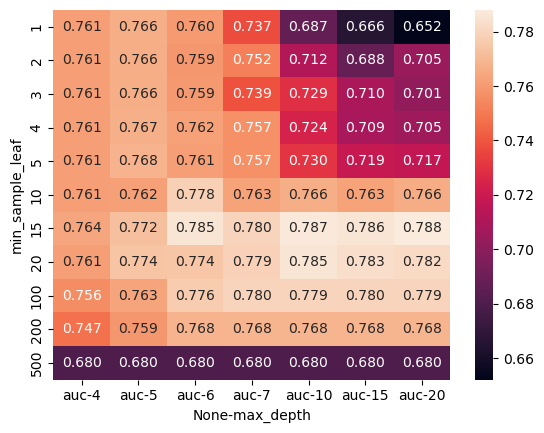

In [39]:
# we can create a heatmap with the result from the preceeding cell

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

**4, 5, 6**

The map above shows that the highest one is the `lightest` color while the worst is the `darkest` one. From the map, we see that we are interested in the `min_sample_leaf` of `15` and the `auc`, `auc-6` whose `max_depth` is 6.

**4, 5, 6, 7, 10, 15, 20**

We see that in this case, `min_sample_leaf` of `15` and the `auc`, `auc-10` whose `max_depth` is 10.

#### Summary for Tuning Parameters for Decision Trees
- We tune the max_depth
- We then tune the min_sample_leaf

In [40]:
# try the final decision tree
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 6.6 Ensembles and Random Forest
Random Forest is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only select a random subset of features from the original data to make predictions.

In random forest the decision trees are trained independent to each other.

##### Classes, functions, and methods:
`from sklearn.ensemble import RandomForestClassifier`: random forest classifier from sklearn ensemble class.
`plt.plot(x, y)`: draw line plot for the values of y against x values.
`bootstrapping`: training on a subset of the observations


##### Personal Note
Random forest is a way of putting multiple decision trees together.
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
# n_estimators means number of models

# train a model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [43]:
# use the model to predict

y_pred = rf.predict_proba(X_val)[:, 1]

In [44]:
# compute the roc
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [45]:
rf.predict_proba(X_val[[0]]) # type: ignore

array([[0.9, 0.1]])

In [46]:
# we want to see how a model improves when we 
# increase the number of n_estimators

scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [47]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

# from the result, we see how the performance of our model changes
# as we increase the number of estimators

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


Text(0, 0.5, 'AUC')

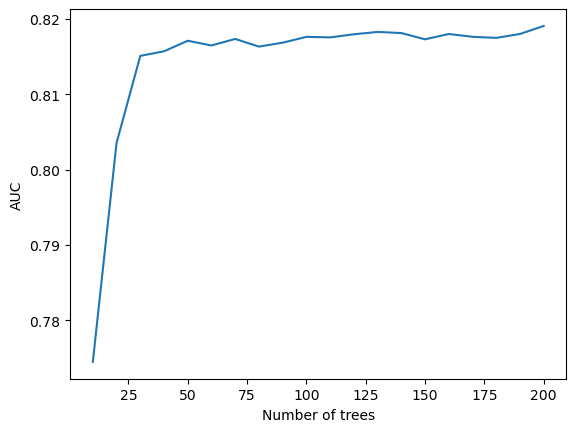

In [48]:
# we plot the dataframe in a graph

plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('Number of trees')
plt.ylabel('AUC')

From the graph above, we see that the line doesn't really grow much after 50. This means that no matter how many more trees we add after 50, the performance of our model isn't really improving. Just like in decision trees, we go ahead to tune the random forest model. The parameters that we tune is the same as in decision trees, `max_depth and min_samples_leaf`.

What we do is take iteration from before and train our random forest model for different `max_depth` parameters.

In [49]:
scores = []
for depths in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=depths, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((depths, n, auc))

In [50]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


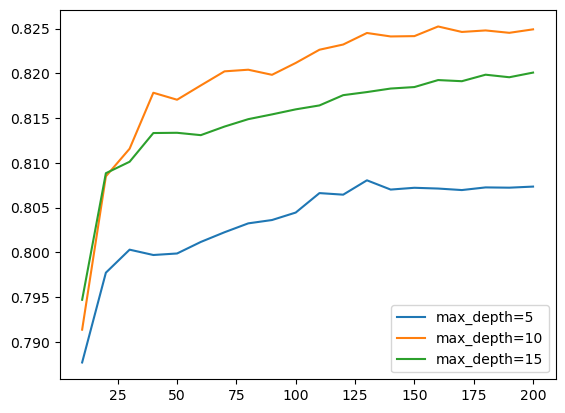

In [51]:
# we plot the dataframe in a graph

for depths in [5, 10, 15]:
    # filtering through the max_depth
    df_subset = df_scores[df_scores.max_depth == depths] 
    plt.plot(df_subset.n_estimators, 
             df_subset.auc, 
             label='max_depth=%d' % depths)

plt.legend()

# from the graph, we can tell that the max_depth of 10 is the best one
# with this info, we can then check for the min_samples_leaf

In [52]:
max_depth = 10

In [53]:
scores = []

for msl in [1, 3, 5, 10, 50]:
        for n in range(10, 201, 10):
                rf = RandomForestClassifier(n_estimators=n, 
                                            max_depth=max_depth,
                                            min_samples_leaf=msl, 
                                            random_state=1)
                rf.fit(X_train, y_train)

                y_pred = rf.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_pred)
                scores.append((msl, n, auc))

In [54]:
columns = ['min_sample_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_sample_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


In [55]:
# customizing the color of our graph
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_sample_leaf_values = [1, 3, 5, 10, 50]

# zip the colors to the numbers
list(zip(min_sample_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

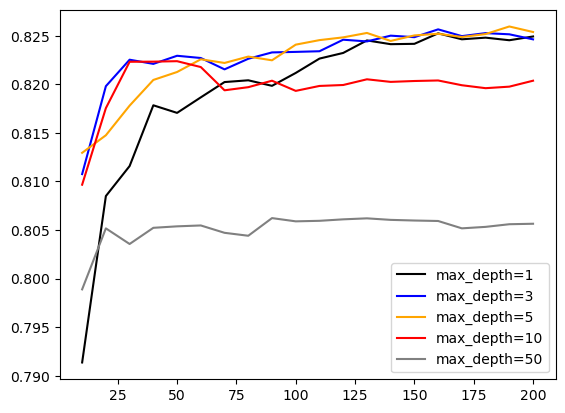

In [56]:
# we plot the dataframe in a graph

# for msl in [1, 3, 5, 10, 50]:
#     df_subset = df_scores[df_scores.min_sample_leaf == msl]
#     plt.plot(df_subset.n_estimators, df_subset.auc, label="max_depth=%d" % msl)

# plt.legend()

# with the cutom colors
for msl, col in zip(min_sample_leaf_values, colors):
    df_subset = df_scores[df_scores.min_sample_leaf == msl]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label="max_depth=%d" % msl)

plt.legend()

# from the graph, we can tell that the max_depth of 10 is the best one
# with this info, we can then check for the min_samples_leaf

From the graph above, we can see that the max_depth of 50 is the worst one while the the max_depths of 1, 3, 5 are great depths. Going with the max_depth of 3 (which the blue color) makes a lot of sense since it experienced a steady increase from 25 on the x-axis and was steady through to 200 unlike the max_depth of 1 which wasn't doing so well before it became steady like the others or max_depth of 5 which did fairly ok just before 75.

With our findings thus far, we can retrain a model

In [57]:
min_sample_leaf = 3

In [58]:
rf = RandomForestClassifier(n_estimators=n, 
                            max_depth=max_depth,
                            min_samples_leaf=min_sample_leaf, 
                            random_state=1)
rf.fit(X_train, y_train)

# this is our final random forest model which we will use when
# comparing different models at the end. There are other parameters
# that can be tuned such as 
# max_features(specifies how many features each decision tree gets)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

## 6.7 Gradient Boosting and XGBoost
Unlike Random Forest where each decision tree trains independently, in the Gradient Boosting Trees, the models are combined sequentially where each model takes the prediction errors made my the previous model and then tries to improve the prediction. This process continues to n number of iterations and in the end all the predictions get combined to make final prediction.

XGBoost is one of the libraries which implements the gradient boosting technique. To make use of the library, we need to install with `pip install xgboost`. To train and evaluate the model, we need to wrap our train and validation data into a special data structure from XGBoost which is called `DMatrix`. This data structure is optimized to train xgboost models faster.

##### Classes, functions, and methods:
- `xgb.train()`: method to train xgboost model.
- `xgb_params`: key-value pairs of hyperparameters to train xgboost model.
- `watchlist`: list to store training and validation accuracy to evaluate the performance of the model after each training iteration. The list takes tuple of train and validation set from DMatrix wrapper, for example, watchlist = [(dtrain, 'train'), (dval, 'val')].
- `%%capture output`: IPython magic command which captures the standard output and standard error of a cell.


### Extracting results from xgb.train(..)
In the video we use jupyter magic command `%%capture output` to extract the output of `xgb.train(..)` method.

Alternatively you can use the `evals_result` parameter of the `xgb.train(..)`. You can pass an empty dictionary in for this parameter and the train() method will populate it with the results. The result will be of type `OrderedDict` so we have to transform it to a dataframe. For this, `zip()` can help. Here's an example code snippet:

        evals_result = {}

        model = xgb.train(params=xgb_params,
                dtrain=dm_train,
                num_boost_round=200,
                verbose_eval=5,
                evals=watchlist,
                evals_result=evals_result)

        columns = ['iter', 'train_auc', 'val_auc']
        train_aucs = list(evals_result['train'].values())[0]
        val_aucs = list(evals_result['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(train_aucs) + 1),
                train_aucs,
                val_aucs
            )), columns=columns)

            plt.plot(df_scores.iter, df_scores.train_auc, label='train')
            plt.plot(df_scores.iter, df_scores.val_auc, label='val')
            plt.legend()


### Installing XGBoost on Mac
Some students reported problems with installing XGBoost on Mac.

When you run `pip install xgboost` and when you try to `import xgboost` in a script you might get an warning or error stating that libomp has not been installed and to run `brew install libomp` in the terminal.

Be careful: this will install a version of libomp that does not work with `xgboost`!

This shows in one of two ways after attempting to run `xgb.DMatrix(X_train, label=y_train, feature_names=features)`:

python script: Segmentation fault: 11
jupyter notebook: Never finished running, and notebook is unresponsive until kernal restart. However confusingly it sometimes works

##### Conda
If you use anaconda or miniconda, try installing xgboost with conda.

- First, uninstall xgboost with pip (if you already installed it previously with pip):

        pip uninstall xgboost

- Then re-install it with conda:

        conda install -c conda-forge xgboost  

It will also install the required version of libomp.

##### Without conda
If you don't use conda, you can manualy install a different version of libopm that works well with XGBoost.

The versions of libomp with this problem are 12.x.x and 13.x.x, however issue has a workaround [xgboost issue #7039](https://github.com/dmlc/xgboost/issues/7039) installing the older libomp 11 using the terminal. In the terminal run `brew list --version libomp`, to determine the current version of libomp if any. Then if you have a problematic version run `brew unlink libomp`.

To install the old version of libomp run:

        brew update
        wget https://raw.githubusercontent.com/chenrui333/homebrew-core/0094d1513ce9e2e85e07443b8b5930ad298aad91/Formula/libomp.rb
        brew install --build-from-source ./libomp.rb

and then run:
        brew list --version libomp

to check that everything worked, it should now state libomp 11.1.0, and your code should now be able to run.


##### Personal Note
`Gradient Boosting` is one way to combine multiple decision trees into one ensemble. You take a dataset and train multiple individual decision trees and combine the result into one single prediction by looking for their average.

We take a dataset, we train the `first model`, then this model makes predictions, then we take the errors that the model made and based on the errors gotten, another `model 2` is trained to correct the predictions of `model 1`. We then take `model 2` and repeat the same process to get `model 3` and also repeat the same process. Finally, we take the multiple predicitons gotten from the models and combine them into one final prediction. If we take the models and replace them with trees, we will have, `Gradient Boosted Trees` or `Gradient Boosting Trees`.

We install using:
- pip: `pip install xgboost` or
- conda: `conda install -c conda-forge xgboost`
 
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing XGBoost's monitoring output

In [59]:
import xgboost as xgb

In [61]:
# wrap our training data into a special data structure
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names=features)

In [65]:
# train a model
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [66]:
model.predict(dval)

array([0.08926772, 0.0468099 , 0.09692743, 0.17261842, 0.05435968,
       0.12576081, 0.08033007, 0.61870354, 0.486538  , 0.04056795,
       0.17517005, 0.62189645, 0.5297428 , 0.07776041, 0.16483201,
       0.79829365, 0.07249691, 0.6842603 , 0.06852661, 0.31414455,
       0.06462585, 0.32278952, 0.05878764, 0.39525822, 0.5182789 ,
       0.11134427, 0.6883214 , 0.1505679 , 0.76725644, 0.04082454,
       0.8889134 , 0.33606657, 0.23066957, 0.47511232, 0.04165092,
       0.04085815, 0.88967437, 0.5634839 , 0.26742017, 0.7305126 ,
       0.11007789, 0.8559642 , 0.07863586, 0.5492019 , 0.05411167,
       0.03366492, 0.5001199 , 0.03741197, 0.13945737, 0.16777565,
       0.04419041, 0.1847458 , 0.05965295, 0.41278166, 0.53473985,
       0.12220522, 0.03110003, 0.23713005, 0.05129844, 0.07587688,
       0.08706387, 0.1566342 , 0.14094234, 0.32264814, 0.12290021,
       0.47798058, 0.32882994, 0.09538577, 0.13444112, 0.06950612,
       0.05668955, 0.07587893, 0.05555102, 0.08185372, 0.25377

In [64]:
# compute auc score

roc_auc_score(y_val, y_pred)

0.8056446925480127

In [67]:
# monitor the performance of our model on each iteration during training

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
%%capture output
# we can get the result of this cell out by capturing it in a string so that we can plot the graph for it

# train a model
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}

# model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round=200)
model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round=200, verbose_eval=5)
# verbose_eval can be used to dictate the intervals for the result prints(in our case, every 5 steps)

In [82]:
s = output.stdout

In [85]:
line = s.split('\n')[0]

In [88]:
num_iter, train_auc, val_auc = line.split('\t')

num_iter, train_auc, val_auc

('[0]', 'train-auc:0.86300', 'val-auc:0.76818')

In [112]:
# we need to extract only the numbers for each - strip/split them

# num_iter 
num_iter = int(num_iter.strip('[]'))

# train_auc
train_auc = train_auc.split(':')[1]

# val_auc
val_auc = val_auc.split(':')[1]

num_iter, train_auc, val_auc


(0, '0.86300', '0.76818')

In [104]:
# a function that returns a dataframe with the elements from the prev
# cell

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [113]:
df_scores = parse_xgb_output(output)

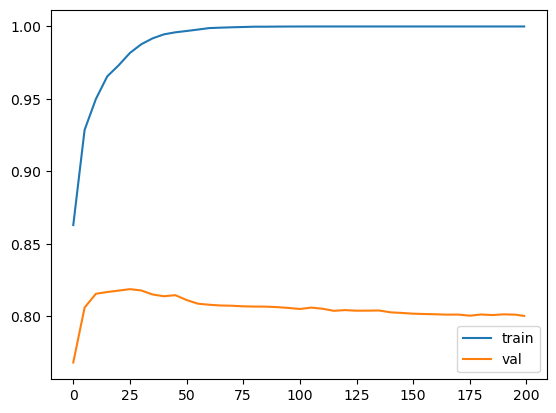

In [114]:
# plot the result from the preceeding cells in a graph

plt.plot(df_scores.num_iter, df_scores.train_auc, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label = 'val')
plt.legend()

From the graph above, we see that the auc for train is always growing. 

## 6.8 XGBoost Parameter Tuning

XGBoost has various tunable parameters but the three most important ones are:

- `eta` (default=0.3)
    - It is also called learning_rate and is used to prevent overfitting by regularizing the weights of new features in each boosting step. range: [0, 1]
- `max_depth` (default=6)
    - Maximum depth of a tree. Increasing this value will make the model mroe complex and more likely to overfit. range: [0, inf]
- `min_child_weight` (default=1)
    - Minimum number of samples in leaf node. range: [0, inf]

For XGBoost models, there are other ways of finding the best parameters as well but the one we implement in the notebook follows the sequence of:

- First find the best value for eta
- Second, find the best value for max_depth
- Third, find the best value for min_child_weight


##### Other useful parameter are:
- `subsample` (default=1)
   - Subsample ratio of the training instances. Setting it to 0.5 means that model would randomly sample half of the trianing data prior to growing trees. range: (0, 1]
- `colsample_bytree` (default=1)
   - This is similar to random forest, where each tree is made with the subset of randomly choosen features.
- `lambda` (default=1)
    - Also called reg_lambda. L2 regularization term on weights. Increasing this value will make model more conservative.
- `alpha` (default=0)
    - Also called reg_alpha. L1 regularization term on weights. Increasing this value will make model more conservative.

##### Personal Note
Tuning the following parameters:
- eta: learning rate - it is saying how much weight the 2nd prediction/model has when it is correcting the 1st prediction/model.
- max_depth: same as in random forest
- min_child_weight: same as min_sample_leaf

Order of tuning: eta -> max_depth -> min_child_weight

In [115]:
scores = {}

In [137]:
%%capture output
# we can get the result of this cell out by capturing it in a string so that we can plot the graph for it

# train a model
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}

# model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round=200)
model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round=200, verbose_eval=5)
# verbose_eval can be used to dictate the intervals for the result prints(in our case, every 5 steps)

In [138]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [139]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    0.86300  0.76818
 1          5    0.92863  0.80606
 2         10    0.95002  0.81558
 3         15    0.96558  0.81680
 4         20    0.97316  0.81775
 5         25    0.98174  0.81878
 6         30    0.98772  0.81787
 7         35    0.99180  0.81510
 8         40    0.99456  0.81387
 9         45    0.99596  0.81462
 10        50    0.99688  0.81128
 11        55    0.99787  0.80874
 12        60    0.99889  0.80801
 13        65    0.99919  0.80751
 14        70    0.99944  0.80732
 15        75    0.99964  0.80692
 16        80    0.99985  0.80677
 17        85    0.99986  0.80671
 18        90    0.99992  0.80637
 19        95    0.99996  0.80580
 20       100    0.99998  0.80508
 21       105    0.99999  0.80603
 22       110    1.00000  0.80527
 23       115    1.00000  0.80382
 24       120    1.00000  0.80431
 25       125    1.00000  0.80391
 26       130    1.00000  0.80395
 27       135    1.00000  0.80404
 28

In [140]:
scores['eta=1.0']

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.95852,0.79032
2,10,0.98435,0.77716
3,15,0.99550,0.78110
4,20,0.99824,0.78091
5,25,0.99980,0.78252
6,30,0.99995,0.77850
7,35,1.00000,0.77592
8,40,1.00000,0.77689
9,45,1.00000,0.77701


In [141]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

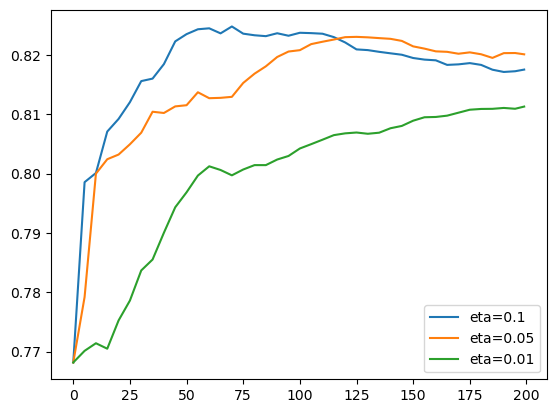

In [146]:
# we'll plot the scores
# etas = ['eta=1.0', 'eta=0.3', 'eta=0.1'] 0.1 is great
# etas = ['eta=0.3', 'eta=0.1', 'eta=0.01'] 0.1 still
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']  

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

From the graph, we can see that 1.0 is worst followed by 0.3 but 0.1 is a great learning rate, it learns slower but better.

Next is to check the max_depth parameter

In [161]:
scores = {}

In [172]:
%%capture output

# train a model
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # we use 6 as a baseline for comparing diff values
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}


model = xgb.train(xgb_params, dtrain, evals = watchlist, 
num_boost_round=200, verbose_eval=5)


In [173]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

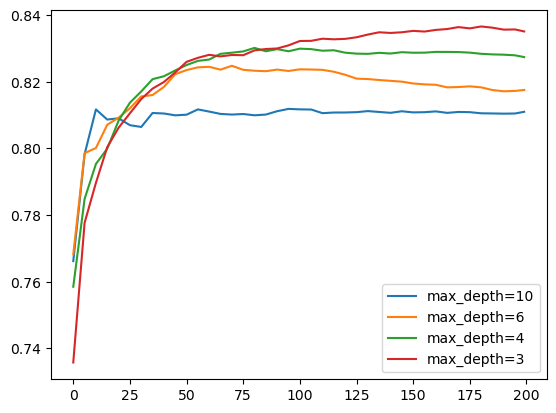

In [174]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

We see that 10 is worse because we see that after a certain point, it stops growing. We can go ahead and delete 10.

In [175]:
del scores['max_depth=10']

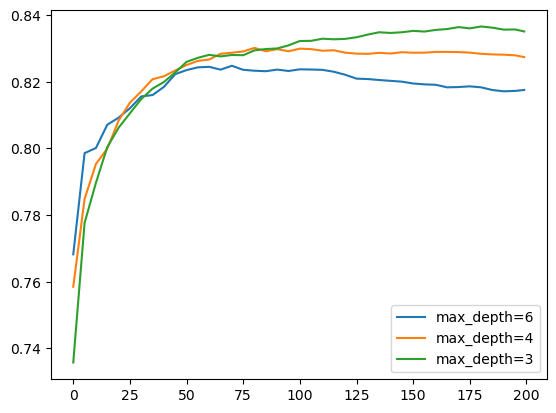

In [179]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

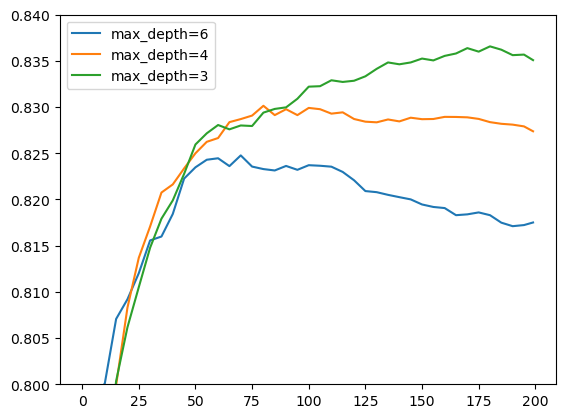

In [180]:
# we want to limit the values on the y-axis to btw 0.80 and 0.84
# where the minimum is 0.8 and the maximum 0.84

for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

We can clearly see what is happening. After about an iteration of 75, the max_depth of 6 declines fast. At about the same number of iterations, the max_depth of 4 declines but steadily. We see that max_depth of 3 keeps growing to up until about an iteration of 175 - though this requires more iteration to learn, the max_depth of 3 has only 3 levels 

The next step is to tune the min_child_weight

In [182]:
scores = {}

In [201]:
%%capture output

# train a model
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # we use 6 as a baseline for comparing diff values
    'min_child_weight': 2, # we use 6 as a baseline

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}


model = xgb.train(xgb_params, dtrain, evals = watchlist, 
num_boost_round=200, verbose_eval=5)


In [202]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=2'

In [206]:
# del scores['min_child_weight=50']
# del scores['min_child_weight=5']
del scores['min_child_weight=40']
del scores['min_child_weight=2']

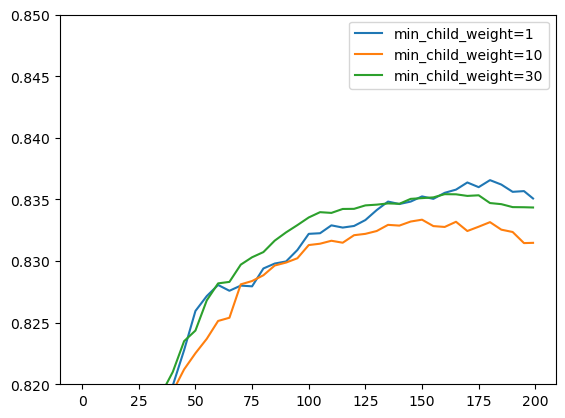

In [208]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.85)
plt.legend()

the min_child_weight of 1 seems to be doing much better and 175 seems like a good number of iteration, so we will update the `num_boost_round`. With all the tuning done, we can now go ahead to train the models with the optimal values discovered. This will be our final model.

other useful parameter includes:
- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

In [211]:
%%capture output

# train a model
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # we use 6 as a baseline for comparing diff values
    'min_child_weight': 1, # we use 1 as a baseline

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}


model = xgb.train(xgb_params, dtrain, evals = watchlist, 
num_boost_round=175)


## 6.9 Selecting the Final Model
We select the final model from decision tree, random forest, or xgboost based on the best auc scores. After that we prepare the df_full_train and df_test to train and evaluate the final model. If there is not much difference between model auc scores on the train as well as test data then the model has generalized the patterns well enough.

Generally, XGBoost models perform better on tabular data than other machine learning models but the downside is that these model are easy to overfit cause of the high number of hyperparameter. Therefore, XGBoost models require a lot more attention for parameters tuning to optimize them.

##### Personal Note
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

We take our best `decision tree`, `random forest` and `xgboost` models and evaluate them on the validation dataset, then go ahead to select the best one.

In [216]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [220]:
# decision tree
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7854738320699426

In [217]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [221]:
# random forest
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [218]:
%%capture output

# train a model
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # we use 6 as a baseline for comparing diff values
    'min_child_weight': 1, # we use 1 as a baseline

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    "verbosity": 1,
}


model = xgb.train(xgb_params, dtrain, evals = watchlist, 
num_boost_round=175)


In [224]:
# xgboost
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

Comparing all 3 models, we can see that `xgboost` is the best model. With this information, we can train the final model using the full dataset(train and validation datasets) and then evaluate the model on our test dataset.

In [226]:
df_full_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
3668,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
2540,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
279,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3536,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
3866,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
1293,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
4023,ok,2,parents,36,25,single,no,fixed,35,110.0,0.0,0.0,500,1200
3775,ok,4,other,60,25,single,no,fixed,35,162.0,0.0,0.0,1800,2999


In [227]:
# reset index
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3559,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3560,ok,2,parents,36,25,single,no,fixed,35,110.0,0.0,0.0,500,1200
3561,ok,4,other,60,25,single,no,fixed,35,162.0,0.0,0.0,1800,2999


In [229]:
# we need to get our y(label)

# y_full_train = df_full_train.status

# we need it as number rep not words(default, ok)
y_full_train = (df_full_train.status == 'default').astype(int).values
y_full_train

array([0, 1, 0, ..., 0, 0, 1])

In [230]:
# we can delete the status column from our full dataset

del df_full_train['status']

In [231]:
# now we need our dictionaries
dicts_full_train = df_full_train.to_dict(orient='records')

# turn the dictionaries into vectors using dictionary vectorizer
dv = DictVectorizer(sparse=False)

# get the feature matrix by fitting and transforming our 
# train dictionary
X_full_train = dv.fit_transform(dicts_full_train)

# get the feature matrix of our test dataset by transforming our 
# test dictionary
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [240]:
# using xgboost

# full train dataset
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, 
                    feature_names=dv.get_feature_names_out())

# test dataset
# we don't need labels in the test because we will evaluate it outside
# of xgboost using scikit-learn
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [241]:
# we will get our final parameters for xgboost and train our final model

In [242]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [245]:
# let's evaluate the model: the full train is stored in a variable
# `model` and test is passed into the y_pred

y_pred = model.predict(dtest)

In [246]:
y_pred[:10]

array([0.24035443, 0.18355751, 0.0865014 , 0.23431301, 0.3524028 ,
       0.28965375, 0.00877119, 0.02481344, 0.21857312, 0.23013479],
      dtype=float32)

In [248]:
roc_auc_score(y_test, y_pred)

0.8322662626460096


The score is almost the same as the one gotten when comparing all three models to choose the best one. It didn't overfit and generalized quite well with unseen data even though we used our validation dataset in tuning the data, we didn't accidentally overfit. We can say the performance on the test dataset is relatively good. 

XGBoost is a great model but it has downsides such as:
- It is more complex and difficult to tune
- It has a lot more parameters
- It is easier to overfit with XGBoost but can get better performance

## 6.10 Summary

- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combining multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.


### Explore More
- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
- XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
- Experiment with other XGBoost parameters: subsample and colsample_bytree.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for random forest (it's the same for plain decision trees) and for xgboost
- Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.